# Mapping the Vegetation Cover Map for Chicago
In this section, we use `rasterio` to `clip`, `mosaic`, and conduct `zonal` analysis on raster data.

In [1]:
import os, os.path
import numpy as np
import rasterio as rio
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import get_data_window
from rasterio.windows import Window
from rasterio.merge import merge
# optional - turn off warnings
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

## Mosaic tiles into a large raster

In [7]:
# This function is used to mosaic geotiffs in the input folder
# Parameters:
#     dirpath: the folder name of the tif files
#     outfile: the output file of the mosaiced geotiff image

import rasterio
# import ogr
import fiona
import os, os.path
from rasterio.merge import merge
import glob
from shapely.geometry import Polygon
from shapely.geometry import shape


# mosaicRasters(folder, os.path.join(root, 'naip-atlanta.tif'))
inputfolder= 'chicago-naip'
outfile = 'data/mosacied-naip-chicago.tif'

# start to mosaic the raster tiles
tiflist = []

for file in os.listdir(inputfolder):    
    if file.endswith('.tif'):
        tiffile = os.path.join(inputfolder, file)
        tiflist.append(tiffile)


src_files_to_mosaic = []
for fp in tiflist:
    try:
        tile_src = rasterio.open(fp)
        tile_bounds = tile_src.bounds
        
        src_files_to_mosaic.append(tile_src)
    except:
        continue

print('The number of mosaiced tiles is:', len(src_files_to_mosaic))

# the method can be set as min, max..
mosaic, out_trans = merge(src_files_to_mosaic) #, method='max'
print('You have mosaiced the results')


# Prepare the schema of the output mosacied image
out_meta = tile_src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans, 
                  "compress": 'lzw',
                  'BIGTIFF': 'YES'
                  }
               )

#out_fp = os.path.join(dirpath, 'atlanta-naip.tif')
with rasterio.open(outfile, "w", **out_meta) as dest:
     dest.write(mosaic)


The number of mosaiced tiles is: 36
You have mosaiced the results


Resampling to 41232,26633


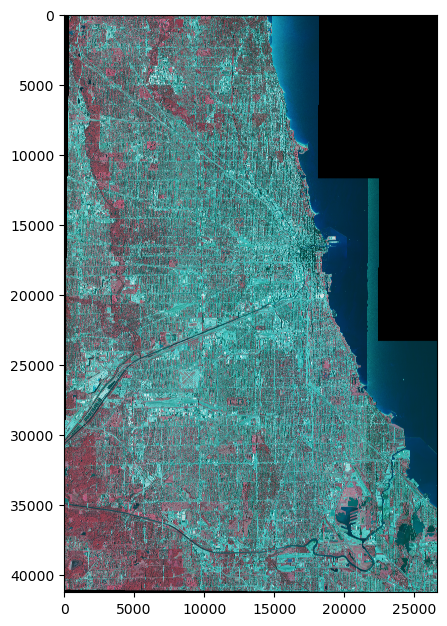

In [8]:
def display_naip_tile(filename, dsfactor = 2):
    """
    Display a NAIP tile using rasterio.
    
    dsfactor: downsample factor
    For .mrf-formatted tiles (which span multiple files), 'filename' should refer to the 
    .mrf file.
    """
    
    # NAIP tiles are enormous; downsize for plotting in this notebook
    
    with rasterio.open(filename) as raster:
        # rasterio uses 1-based indexing for channels.
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        print('Resampling to {},{}'.format(h,w))
        ir = raster.read(4, out_shape=(1, h, w))
        r = raster.read(1, out_shape=(1, h, w))
        g = raster.read(2, out_shape=(1, h, w))
        
    cir = np.dstack((ir,r,g))
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100, edgecolor='k')
    plt.imshow(cir)
    raster.close()
    
naip_file = 'data/mosacied-naip-chicago.tif'
display_naip_tile(naip_file)

## Mask the mosaiced raster to Chicago

In [ ]:
# Reproject the shapefile to match the raster
from pyproj import Transformer
import geopandas as gpd

shp = gpd.read_file("data/chicagoBoundary.shp")
shp = shp.to_crs(src.crs)  # Reproject to match raster
shp.to_file("data/chicagoBoundary_reprojected.shp")

In [19]:
import fiona

input_value_raster = 'data/mosacied-naip-chicago.tif'
shpfile = 'data/chicagoBoundary_reprojected.shp'
out_raster = 'data/maskChicago-naip.tif'


with fiona.open(shpfile, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(input_value_raster) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "count": out_image.shape[0],  # Ensure correct number of bands
                 "dtype": out_image.dtype,  # Ensure correct data type
                 "compress": None,
                 "transform": out_transform})

with rasterio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image)

## Clip a large raster data into small tiles

In [20]:
lu_dataset = rasterio.open('data/maskChicago-naip.tif')
outfolder = 'data/chicago-naip-tiles'
if not os.path.exists(outfolder):
    os.mkdir(outfolder)


lu_img = lu_dataset.read()

# height and width of the raster
height, width = lu_dataset.shape

# split the large raser into number of tiles, tile size is 2000*2000
tile_width = 2000
tile_height = 2000

tile_num_col = int(width/tile_width) + 1
tile_num_row = int(height/tile_height) + 1

# the output folder
if not os.path.exists(outfolder): os.mkdir(outfolder)

# create each tile
for i in range(tile_num_row - 1):
    # loop each column
    for j in range(tile_num_col - 1):
        print('The i and j is:', i, j)
        tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
        
        row_start = i*tile_height
        col_start = j*tile_width
        row_end = (i + 1)*tile_height
        col_end = (j + 1)*tile_width
        
        # deal with the right boundary
        if row_end > height - 1: tile_height = height - row_start
        if col_end > width - 1: tile_width = width - col_start
        
        # window = get_data_window(lu_dataset.read(1, masked=True))
        window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)
        
        kwargs = lu_dataset.meta.copy()
        kwargs.update({
            'height': window.height,
            'width': window.width,
            'transform': rasterio.windows.transform(window, lu_dataset.transform)})
        
        with rasterio.open(tilename, 'w', **kwargs) as dst:
            dst.write(lu_dataset.read(window=window))

The i and j is: 0 0
The i and j is: 0 1
The i and j is: 0 2
The i and j is: 0 3
The i and j is: 0 4
The i and j is: 0 5
The i and j is: 0 6
The i and j is: 0 7
The i and j is: 0 8
The i and j is: 0 9
The i and j is: 0 10
The i and j is: 0 11
The i and j is: 0 12
The i and j is: 0 13
The i and j is: 0 14
The i and j is: 0 15
The i and j is: 0 16
The i and j is: 0 17
The i and j is: 0 18
The i and j is: 0 19
The i and j is: 0 20
The i and j is: 1 0
The i and j is: 1 1
The i and j is: 1 2
The i and j is: 1 3
The i and j is: 1 4
The i and j is: 1 5
The i and j is: 1 6
The i and j is: 1 7
The i and j is: 1 8
The i and j is: 1 9
The i and j is: 1 10
The i and j is: 1 11
The i and j is: 1 12
The i and j is: 1 13
The i and j is: 1 14
The i and j is: 1 15
The i and j is: 1 16
The i and j is: 1 17
The i and j is: 1 18
The i and j is: 1 19
The i and j is: 1 20
The i and j is: 2 0
The i and j is: 2 1
The i and j is: 2 2
The i and j is: 2 3
The i and j is: 2 4
The i and j is: 2 5
The i and j is: 2 

## Loop all the split tiles can compute the vegetation cover

In [21]:
out_tif = 'data/chicago-veg.tif'

infolder = 'data/chicago-naip-tiles'
outfolder = 'data/chicago-veg-tiles'

if not os.path.exists(outfolder):
    os.mkdir(outfolder)


for file in os.listdir(infolder):
    tiffile = os.path.join(infolder, file)
    
    # read the different bands of the raster data
    if not tiffile.endswith('.tif'): continue
    naip_dataset = rio.open(tiffile)
    green = np.float32(naip_dataset.read(3))
    red = np.float32(naip_dataset.read(2))
    nir = np.float32(naip_dataset.read(1))

    # here add 0.0000001 is to make sure the nir+red is not zero
    ndvi = (nir - red)/(nir + red + 0.000001)
    
    # extract the vegetation based on the ndvi
    veg = np.zeros((ndvi.shape[0], ndvi.shape[1]), dtype = np.uint16)
    veg[ndvi > 0] = 1
    
    
    # prepare the schema of the new tiles
    out_meta = naip_dataset.meta.copy()

    # update the schema of the ndvi image, because it is different from teh raw naip image, like only one band
    out_meta.update({'count': 1,
                    'dtype': 'uint16',
                     "height": ndvi.shape[0],
                     "width": ndvi.shape[1],
    #                  "transform": out_transform,
                     "crs": naip_dataset.crs, 
                     'compress': 'lzw'}
                   )
    
    
    # this is required, because rio will use three dimension, even this is single band image
    veg = veg.reshape(1, veg.shape[0], veg.shape[1])
    
    out_tif = os.path.join(outfolder, file)
    with rio.open(out_tif, "w", **out_meta) as dest:
        dest.write(veg)
    

## Generate a NDVI map by census tract

In [ ]:
import fiona

with fiona.open("data/chicagoBoundary_reprojected.shp", "r") as shapefile:
    print(shapefile.crs)

EPSG:26916


In [24]:
import fiona
import shapely
from shapely.geometry import shape
import rasterio
import rasterio.mask
import os, os.path
import numpy as np


inraster = 'data/maskChicago-naip.tif'
input_zone_polygon = 'data/tract23_chicago_26916.shp'
output_shp_res = 'data/chicago-vegCoverCensus-tract.shp'


# Open the raster datasets
naip_dataset = rasterio.open(inraster)


# Prepare the polygon shapefile and then do the overlay of the raster data and the vector data
lyr = fiona.open(input_zone_polygon)
schema = lyr.schema
schema['properties']['ndvi'] = 'float'


with fiona.open(output_shp_res, 'w', driver = "ESRI Shapefile", crs = lyr.crs, schema=schema) as output:
    for idx, feat in enumerate(lyr):
        props = feat['properties']
        geom = feat['geometry']
        shape = [geom] # the rasterio need the list, therefore, create a list
        
        # mask the raster using the polygon
        outNAIP_image, out_transform = rasterio.mask.mask(naip_dataset, shape, 
                                                          nodata = 0,
                                                          crop=True)
        
        # calculate the ndvi from the clipped naip img, convert the int to float using numpy
        nir = np.float32(outNAIP_image[0, :, :])
        red = np.float32(outNAIP_image[1, :, :])
        ndvi = (nir - red)/(nir + red + 0.000001)
        
        # calculate the ndvi value
        mean_val = np.sum(ndvi)/np.count_nonzero(ndvi)
        
        # update the calculated ndvi value to the field
        props['ndvi'] = mean_val
        output.write({'properties': props,
                      'geometry': geom
                     })
        

In [ ]:
shpfile = 'data/chicago-vegCoverCensus-tract.shp'
gpddf = gpd.read_file(shpfile)
gpddf['veg'] = gpddf['ndvi'].apply(lambda x: 'Vegetation' if x > 0 else 'Non-Vegetation')
gpddf.head()

,GEOID,NAME,ndvi,geometry,veg
0,17031740200,Census Tract 7402; Cook County; Illinois,-0.007493,"POLYGON ((440038.395 4618182.139, 440038.717 4...",Non-Vegetation
1,17031740100,Census Tract 7401; Cook County; Illinois,-0.002806,"POLYGON ((442075.242 4616587.072, 442086.039 4...",Non-Vegetation
2,17031530501,Census Tract 5305.01; Cook County; Illinois,-0.018104,"POLYGON ((447373.308 4614210.144, 447773.874 4...",Non-Vegetation
3,17031750300,Census Tract 7503; Cook County; Illinois,-0.000318,"POLYGON ((442747.446 4616588.332, 442791.718 4...",Non-Vegetation
4,17031826500,Census Tract 8265; Cook County; Illinois,0.008929,"MULTIPOLYGON (((448637.463 4610499.828, 448630...",Vegetation


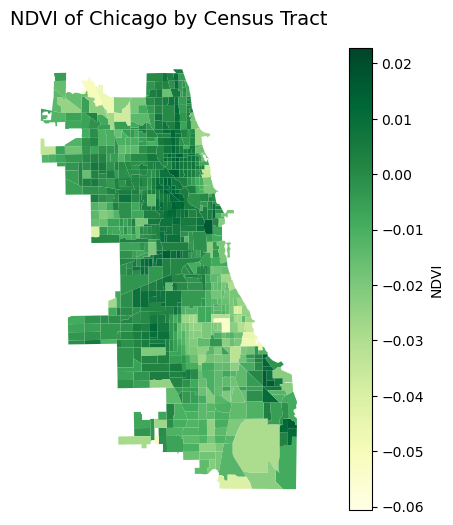

In [55]:
ax = gpddf.plot(
    column="ndvi", 
    cmap="YlGn", 
    legend=True,
    legend_kwds={"label": "NDVI"},
    figsize=(10, 6),  # Optional: Adjust figure size
    missing_kwds={
        "color": "lightgrey"  # Color for NaN values
    }
)
ax.set_axis_off()
# Add a title using matplotlib
plt.title("NDVI of Chicago by Census Tract", fontsize=14)
plt.show()

## Generate a vegetation map by census tract

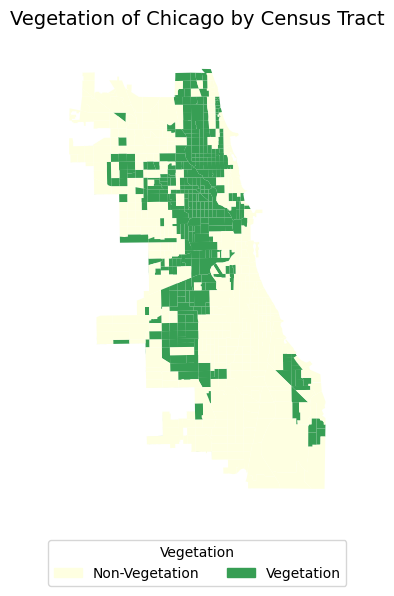

In [68]:
import matplotlib.patches as mpatches
color_map = {
    'Vegetation': '#379E54',
    'Non-Vegetation': '#FEFFE1'}
ax = gpddf.plot(
    column="veg",
    # cmap="YlGn",
    color=gpddf['veg'].map(color_map),
    legend=True,
    figsize=(10, 6),  # Adjust figure size
    missing_kwds={
        "color": "lightgrey"  # Color for NaN values
    }
)
ax.set_axis_off()
# Create custom legend manually based on the color_map
legend_labels = ['Non-Vegetation', 'Vegetation']
legend_colors = ['#FEFFE1', '#379E54']  # Colors corresponding to 'Non-Vegetation' and 'Vegetation'
handles = [mpatches.Patch(color=legend_colors[0], label=legend_labels[0]),
           mpatches.Patch(color=legend_colors[1], label=legend_labels[1])]

# Add the legend to the plot
ax.legend(handles=handles, title="Vegetation", loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
# Add a title using matplotlib
plt.title("Vegetation of Chicago by Census Tract", fontsize=14)

plt.show()